# OpenAI test classification prompts.

In this notebook we are going to use the **Amazon Review Dataset** to test Promptmeteo in the sentiment analysis task

## 1. Data Preparation - EN - Build sentiment dataset.

The dataset contains reviews from Amazon in English collected between November 1, 2015 and November 1, 2019. Each record in the dataset contains the review text, the review title, the star rating, an anonymized reviewer ID, an anonymized product ID and the coarse-grained product category (e.g. ‘books’, ‘appliances’, etc.). The corpus is balanced across stars, so each star rating constitutes 20% of the reviews in each language.

In [1]:
import polars as pl
import sys; sys.path.append('..')

data = pl.read_parquet('../data/amazon_reviews_en/amazon_reviews_multi-test.parquet')
sql = pl.SQLContext()
sql.register('data', data)

sentiment_data = sql.execute("""
    SELECT
        review_body as REVIEW,
        CASE
            WHEN stars=1 THEN 'negative'
            WHEN stars=3 THEN 'neutral'
            WHEN stars=5 THEN 'positive'
            ELSE null
        END AS TARGET,
    FROM data
    WHERE stars!=2 AND stars!=4;
    """).collect().sample(fraction=1.0, shuffle=True, seed=0)

train_reviews = sentiment_data.head(100).select('REVIEW').to_series().to_list()
train_targets = sentiment_data.head(100).select('TARGET').to_series().to_list()

test_reviews = sentiment_data.tail(100).select('REVIEW').to_series().to_list()
test_targets = sentiment_data.tail(100).select('TARGET').to_series().to_list()

sentiment_data.head()

REVIEW,TARGET
str,str
"""I reuse my Nes…","""positive"""
"""Fits great kin…","""positive"""
"""Movie freezes …","""negative"""
"""This is my thi…","""positive"""
"""For the money,…","""neutral"""


In [2]:
token = ''

&nbsp;


&nbsp;


&nbsp;


## 2. EN - Sin entrenamiento

### Prueba 1

<Axes: >

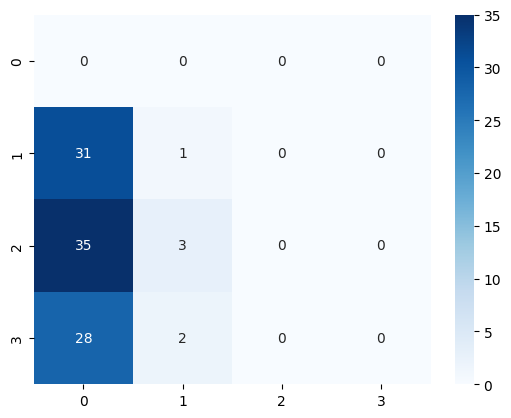

In [3]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'en',
    model_name           = 'gpt-3.5-turbo-instruct',
    model_provider_name  = 'openai',
    model_provider_token = token,
    prompt_domain        = 'product reviews',
    prompt_labels        = ['positive','negative','neutral'],
    selector_k           = 0,
)

pred_targets = model.predict(test_reviews)
pred_targets = [pred if len(pred)==1 else [''] for pred in pred_targets]

sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

### Prueba 2

In [4]:
prompt='''
TEMPLATE:
    "I need you to help me with a text classification task.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    "The texts you will be processing are from the {__DOMAIN__} domain."


PROMPT_LABELS:
    "I want you to classify the texts into one of the following categories:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    "Think step by step you answer."


ANSWER_FORMAT:
    "In your response, include only the name of the class predicted."
'''

<Axes: >

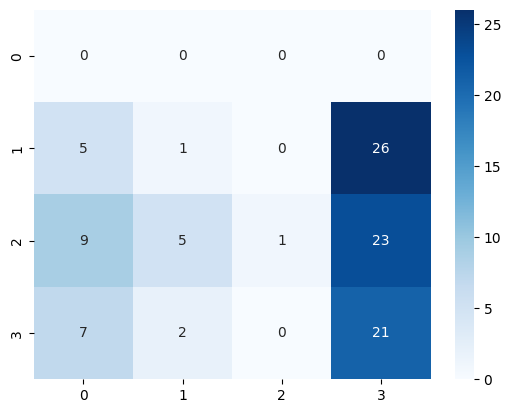

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'en',
    model_name           = 'gpt-3.5-turbo-instruct',
    model_provider_name  = 'openai',
    model_provider_token = token,
    prompt_domain        = 'product reviews',
    prompt_labels        = ['positive','negative','neutral'],
    selector_k           = 0,
)

model.task.prompt.read_prompt(prompt)

pred_targets = model.predict(test_reviews)

sns.heatmap(
    confusion_matrix(test_targets, [i[0] for i in pred_targets]),
    annot=True,
    cmap='Blues')

## 3. EN - Con entrenamiento

### Prueba 1

In [6]:
prompt='''
TEMPLATE:
    "I need you to help me with a text classification task.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__SHOT_EXAMPLES__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    "The texts you will be processing are from the {__DOMAIN__} domain."


PROMPT_LABELS:
    "I want you to classify the texts into one of the following categories:
    {__LABELS__}."


SHOT_EXAMPLES:

    "{__EXAMPLES__}"


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    "Please provide a step-by-step argument for your answer, explain why you
    believe your final choice is justified, and make sure to conclude your
    explanation with the name of the class you have selected as the correct
    one, in lowercase and without punctuation."


ANSWER_FORMAT:
    "In your response, include only the name of the class as a single word, in
    lowercase, without punctuation, and without adding any other statements or
    words."
'''

<Axes: >

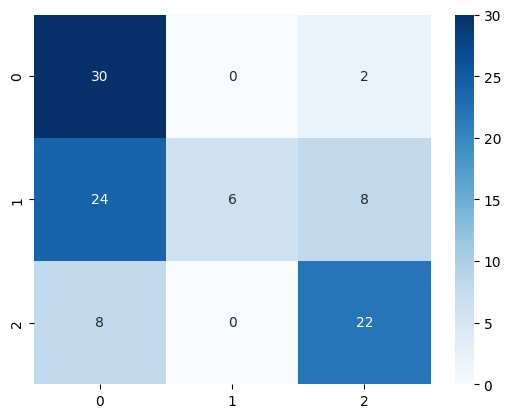

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'en',
    model_name           = 'gpt-3.5-turbo-instruct',
    model_provider_name  = 'openai',
    model_provider_token = token,
    selector_k           = 10,
)

model.task.prompt.read_prompt(prompt)

model.train(
    examples = train_reviews,
    annotations = train_targets
)

pred_targets = model.predict(test_reviews)

sns.heatmap(
    confusion_matrix(test_targets, [i[0] for i in pred_targets]),
    annot=True,
    cmap='Blues')

### Prueba 2

In [8]:
prompt='''
TEMPLATE:
    "I need you to help me with a text classification task.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    "The texts you will be processing are from the {__DOMAIN__} domain."


PROMPT_LABELS:
    "I want you to classify the texts into one of the following categories:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    "Think step by step you answer."


ANSWER_FORMAT:
    "In your response, include only the name of the class predicted."
'''

<Axes: >

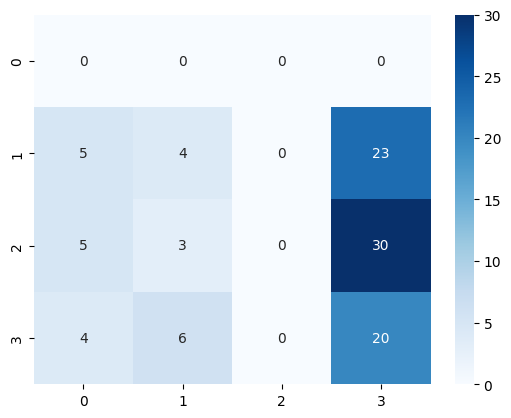

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'en',
    model_name           = 'gpt-3.5-turbo-instruct',
    model_provider_name  = 'openai',
    model_provider_token = token,
    prompt_domain        = 'product reviews',
    prompt_labels        = ['positive','negative','neutral'],
    selector_k           = 20,
)

model.task.prompt.read_prompt(prompt)

model.train(
    examples = train_reviews,
    annotations = train_targets,
)

pred_targets = model.predict(test_reviews)

sns.heatmap(
    confusion_matrix(test_targets, [i[0] for i in pred_targets]),
    annot=True,
    cmap='Blues')

&nbsp;


### Prueba 3

In [10]:
prompt='''
TEMPLATE:
    "I need you to help me with a text classification task.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"

PROMPT_DOMAIN:
    ""

PROMPT_LABELS:
    ""

PROMPT_DETAIL:
    ""

CHAIN_THOUGHT:
    ""

ANSWER_FORMAT:
    ""
'''

<Axes: >

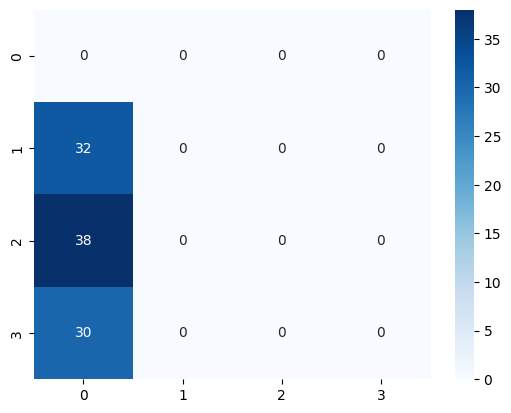

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'en',
    model_name           = 'gpt-3.5-turbo-instruct',
    model_provider_name  = 'openai',
    model_provider_token = token,
    selector_k           = 20,
)

model.task.prompt.read_prompt(prompt)

model.train(
    examples = train_reviews,
    annotations = train_targets,
)

pred_targets = model.predict(test_reviews)

sns.heatmap(
    confusion_matrix(test_targets, [i[0] for i in pred_targets]),
    annot=True,
    cmap='Blues')

&nbsp;


&nbsp;


## 4. Data Preparation - SP - Build sentiment dataset.

In [3]:
import polars as pl

data = pl.read_parquet('../data/amazon_reviews_sp/amazon_reviews_multi-test.parquet')
data.head()

sql = pl.SQLContext()
sql.register('data', data)

sentiment_data = sql.execute("""
    SELECT
        review_body as REVIEW,
        CASE
            WHEN stars=1 THEN 'negative'
            WHEN stars=3 THEN 'neutral'
            WHEN stars=5 THEN 'positive'
            ELSE null
        END AS TARGET,
    FROM data
    WHERE stars!=2 AND stars!=4;
    """).collect().sample(fraction=1.0, shuffle=True, seed=0)
/
train_reviews = sentiment_data.head(100).select('REVIEW').to_series().to_list()
train_targets = sentiment_data.head(100).select('TARGET').to_series().to_list()

test_reviews = sentiment_data.tail(100).select('REVIEW').to_series().to_list()
test_targets = sentiment_data.tail(100).select('TARGET').to_series().to_list()

sentiment_data.head()

REVIEW,TARGET
str,str
"""El filtro de d…","""positive"""
"""Un poquito esc…","""positive"""
"""Para qué decir…","""negative"""
"""Mi hija esta e…","""positive"""
"""Se podría mejo…","""neutral"""


&nbsp;


&nbsp;


&nbsp;


## 5 SP - Sin Entrenamiento

### Prueba 1

In [4]:
prompt='''
TEMPLATE:
    "Necesito que me ayudes en una tarea de clasificación de texto.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    "Los textos que vas procesar del ambito de {__DOMAIN__}."


PROMPT_LABELS:
    "Quiero que me clasifiques los textos una de las siguientes categorías:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    "Por favor argumenta tu respuesta paso a paso, explica por qué crees que
    está justificada tu elección final, y asegúrate de que acabas tu
    explicación con el nombre de la clase que has escogido como la
    correcta, en minúscula y sin puntuación."


ANSWER_FORMAT:
    "En tu respuesta incluye sólo el nombre de la clase, como una única
    palabra, en minúscula, sin puntuación, y sin añadir ninguna otra
    afirmación o palabra."
'''

<Axes: >

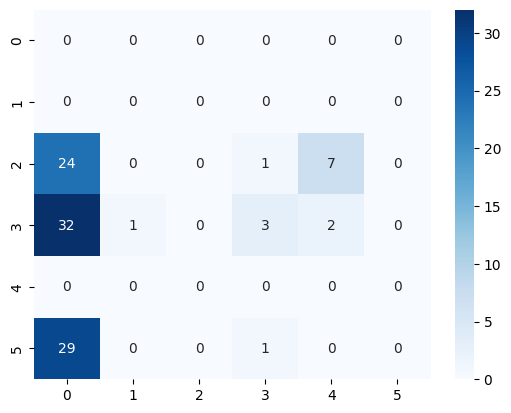

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'es',
    model_name           = 'gpt-3.5-turbo-instruct',
    model_provider_name  = 'openai',
    model_provider_token = token,
    prompt_domain        = 'opiniones de productos',
    prompt_labels        = ['positiva','negativa','neutral'],
    selector_k           = 0,
)

model.task.prompt.read_prompt(prompt)

pred_targets = model.predict(test_reviews)
pred_targets = [pred if len(pred)==1 else [''] for pred in pred_targets]

sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

### Prueba 2

In [6]:
prompt='''
TEMPLATE:
    "Necesito que me ayudes en una tarea de clasificación de texto.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    "Los textos que vas procesar del ambito de {__DOMAIN__}."


PROMPT_LABELS:
    "Quiero que me clasifiques los textos una de las siguientes categorías:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    "Argumenta tu respuesta paso a paso."


ANSWER_FORMAT:
    "En tu respuesta incluye sólo el nombre de la clase, como una única
    respuesta"
'''

<Axes: >

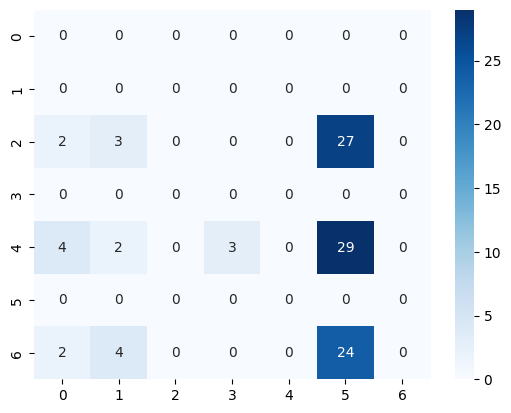

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'es',
    model_name           = 'gpt-3.5-turbo-instruct',
    model_provider_name  = 'openai',
    model_provider_token = token,
    prompt_domain        = 'opiniones de productos',
    prompt_labels        = ['positiva','negativa','neutra'],
    selector_k           = 0,
)

model.task.prompt.read_prompt(prompt)

pred_targets = model.predict(test_reviews)

sns.heatmap(
    confusion_matrix(test_targets, [i[0] for i in pred_targets]),
    annot=True,
    cmap='Blues')

### Prueba 3

In [8]:
prompt='''
TEMPLATE:
    "Necesito que me ayudes en una tarea de clasificación de texto.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    ""


PROMPT_LABELS:
    "Quiero que me clasifiques los textos una de las siguientes categorías:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    ""


ANSWER_FORMAT:
    ""
'''

<Axes: >

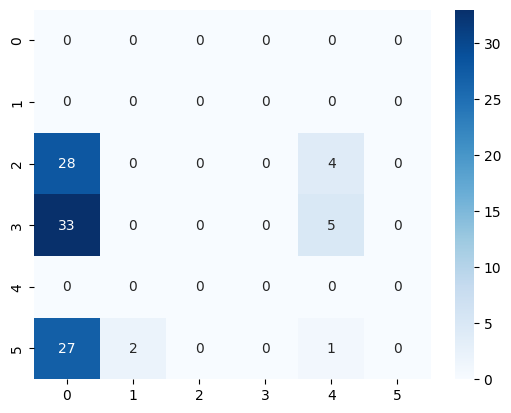

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'es',
    model_name           = 'gpt-3.5-turbo-instruct',
    model_provider_name  = 'openai',
    model_provider_token = token,
    prompt_domain        = 'opiniones de productos',
    prompt_labels        = ['positiva','negativa','neutra'],
    selector_k           = 0,
)

model.task.prompt.read_prompt(prompt)

pred_targets = model.predict(test_reviews)
pred_targets = [pred if len(pred)==1 else [''] for pred in pred_targets]

sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

## ES - Con entrenamiento

### Prueba 1

In [10]:
prompt='''
TEMPLATE:
    "Necesito que me ayudes en una tarea de clasificación de texto.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    "Los textos que vas procesar del ambito de {__DOMAIN__}."


PROMPT_LABELS:
    "Quiero que me clasifiques los textos una de las siguientes categorías:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    "Por favor argumenta tu respuesta paso a paso, explica por qué crees que
    está justificada tu elección final, y asegúrate de que acabas tu
    explicación con el nombre de la clase que has escogido como la
    correcta, en minúscula y sin puntuación."


ANSWER_FORMAT:
    "En tu respuesta incluye sólo el nombre de la clase, como una única
    palabra, en minúscula, sin puntuación, y sin añadir ninguna otra
    afirmación o palabra."
'''

<Axes: >

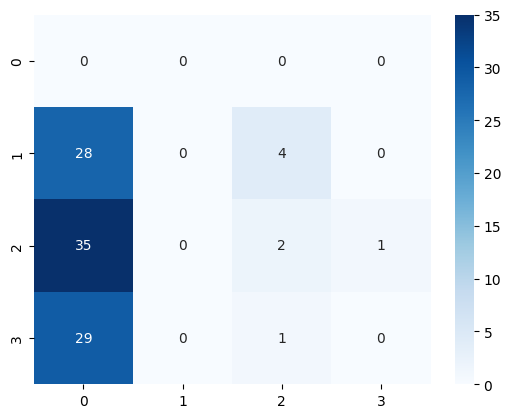

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'es',
    model_name           = 'gpt-3.5-turbo-instruct',
    model_provider_name  = 'openai',
    model_provider_token = token,
    prompt_domain        = 'opiniones de productos',
    prompt_labels        = ['positive','negative','neutral'],
    selector_k           = 10,
)

model.task.prompt.read_prompt(prompt)

model.train(
    examples = train_reviews,
    annotations = train_targets,
)

pred_targets = model.predict(test_reviews)
pred_targets = [pred if len(pred)==1 else [''] for pred in pred_targets]

sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

### Prueba 2

In [24]:
prompt='''
TEMPLATE:
    "Necesito que me ayudes en una tarea de clasificación de texto.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    "Los textos que vas procesar del ambito de {__DOMAIN__}."


PROMPT_LABELS:
    "Quiero que me clasifiques los textos una de las siguientes categorías:
    {__LABELS__}."


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    "Argumenta tu respuesta paso a paso."


ANSWER_FORMAT:
    "En tu respuesta incluye sólo el nombre de la clase, como una única
    respuesta"
'''

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'es',
    model_name           = 'gpt-3.5-turbo-instruct',
    model_provider_name  = 'openai',
    model_provider_token = token,
    prompt_domain        = 'opiniones de productos',
    prompt_labels        = ['positive','negative','neutral'],
    selector_k           = 10,
)

model.task.prompt.read_prompt(prompt)

model.train(
    examples = train_reviews,
    annotations = train_targets,
)

pred_targets = model.predict(test_reviews)
pred_targets = [pred if len(pred)==1 else [''] for pred in pred_targets]

sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

### Prueba 3

In [ ]:
prompt='''
TEMPLATE:
    "Necesito que me ayudes en una tarea de clasificación de texto.
    {__PROMPT_DOMAIN__}
    {__PROMPT_LABELS__}

    {__CHAIN_THOUGHT__}
    {__ANSWER_FORMAT__}"


PROMPT_DOMAIN:
    ""


PROMPT_LABELS:
    ""


PROMPT_DETAIL:
    ""


CHAIN_THOUGHT:
    ""


ANSWER_FORMAT:
    ""
'''

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from promptmeteo import DocumentClassifier

model = DocumentClassifier(
    language             = 'es',
    model_name           = 'gpt-3.5-turbo-instruct',
    model_provider_name  = 'openai',
    model_provider_token = token,
    prompt_domain        = 'opiniones de productos',
    prompt_labels        = ['positive','negative','neutral'],
    selector_k           = 20,
)

model.task.prompt.read_prompt(prompt)

model.train(
    examples = train_reviews,
    annotations = train_targets,
)

pred_targets = model.predict(test_reviews)
pred_targets = [pred if len(pred)==1 else [''] for pred in pred_targets]

sns.heatmap(
    confusion_matrix(test_targets, pred_targets),
    annot=True,
    cmap='Blues')

## Conclusiones

* Parece que con el modelo Flan-t5-small, el mejor resultado se obtiene añadiendo más ejemplot y quitando la instrucción del prompt

* Parece que hay mucho errores asociados con que la respuesta tenga un espacio antes de laa respuesta